# Flight and Weather Preprocessing

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from ast import literal_eval as make_tuple
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType, DoubleType, StructType, StructField
%matplotlib inline

In [2]:
#create Spark session
spark = SparkSession.builder.appName('weather').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '20g'),
                                        ('spark.app.name', 'Spark Updated Conf'),
                                        ('spark.executor.cores', '8'),
                                        ('spark.cores.max', '8'),
                                        ('spark.driver.memory','20g'),
                                        ('spark.sql.debug.maxToStringFields','100')])

## Find unique weather stations and locations for every year

In [ ]:
years = ['2018', '2019','2020', '2021', '2022']

for year in years:
    print('Starting to process ' + year + ' weather data')
    df = spark.read \
        .option("quote", "\"")  \
        .option("escape", "\"") \
        .option("ignoreLeadingWhiteSpace",True) \
        .csv("gs://mscabigdata7fall2022/" + year + ".tar.gz",inferSchema=True, header=True ) \
    .withColumnRenamed(df.columns[0], 'Station')
    
    # grab distinct values of station, latitude and longitude, then save to .csv
    df.select('Station','LATITUDE', 'LONGITUDE') \
    .distinct()\
    .write.csv('gs://mscabigdata7fall2022/weather' + year + 'locations.csv',
               mode="overwrite",
               header=True)

In [ ]:
def grab_yearly_locations(file_path,year):
    
    weather = spark.read \
    .option("quote", "\"")  \
    .option("escape", "\"") \
    .option("ignoreLeadingWhiteSpace",True) \
    .csv(file_path,inferSchema=True, header=True )

    # convert to pandas because the data is small enough
    dat = weather.toPandas()
    
    # filter out misread observations
    dat = dat[dat['Station'].apply(lambda x: len(x) < 20)].copy()
    dat['LATITUDE'] = dat['LATITUDE'].astype(float)
    dat['LONGITUDE'] = dat['LONGITUDE'].astype(float)
    
    dat = dat.melt(id_vars='Station',var_name='loc',value_name=year)
    
    return dat

In [ ]:
dat_2018 = grab_yearly_locations("gs://mscabigdata7fall2022/weather2018locations.csv",2018)
dat_2019 = grab_yearly_locations("gs://mscabigdata7fall2022/weather2019locations.csv",2019)
dat_2020 = grab_yearly_locations("gs://mscabigdata7fall2022/weather2020locations.csv",2020)
dat_2021 = grab_yearly_locations("gs://mscabigdata7fall2022/weather2021locations.csv",2021)
dat_2022 = grab_yearly_locations("gs://mscabigdata7fall2022/weather2022locations.csv",2022)

loc_dat = dat_2018.merge(dat_2019,on=['Station','loc'])\
.merge(dat_2020,on=['Station','loc'])\
.merge(dat_2021,on=['Station','loc'])\
.merge(dat_2022,on=['Station','loc'])

loc_dat.to_csv("gs://mscabigdata7fall2022/annual_station_locations.csv",index=False)

## Find weather stations to find ones closest to the airport

we will do this with the following steps
 1) union all the flight data
 
 2) find all Airport SEQ IDs for airports that are in the flight dataset
 
 3) filter for only airports that have flight data
 
 4) calculate distance between weather stations and airports
 
 5) find the closest weather station for each airport

In [17]:
df2021 = spark.read.csv("gs://mscabigdata7fall2022/Combined_Flights_2021.csv", header=True)
df2020 = spark.read.csv("gs://mscabigdata7fall2022/Combined_Flights_2020.csv", header=True)
df2019 = spark.read.csv("gs://mscabigdata7fall2022/Combined_Flights_2019.csv", header=True)
df2018 = spark.read.csv("gs://mscabigdata7fall2022/Combined_Flights_2018.csv", header=True)
df2022 = spark.read.csv("gs://mscabigdata7fall2022/Combined_Flights_2022.csv", header=True)

#union all flight data
dfallflights=df2021.union(df2022)\
.union(df2020)\
.union(df2019)\
.union(df2018)

In [18]:
# find all Airport SEQ IDs for airports that are in the flight dataset
orgs = dfallflights.select(col('OriginAirportSeqID').alias('seq')).distinct()
ars = dfallflights.select(col('DestAirportSeqID').alias('seq')).distinct()
seqs = orgs.union(ars).distinct().toPandas()

rel_airport_seq_IDs = seqs.to_csv('gs://mscabigdata7fall2022/seqs_in_flight_dat.csv')

In [ ]:
airports = pd.read_csv("gs://mscabigdata7fall2022/T_MASTER_CORD.csv")

# filter for only airports that have flight data
airports = airports.loc[airports['AIRPORT_SEQ_ID'].isin(rel_airport_seq_IDs['seq']),
                        ['AIRPORT_SEQ_ID','LATITUDE','LONGITUDE']].dropna().copy()

In [ ]:
station_loc = pd.read_csv("gs://mscabigdata7fall2022/annual_station_locations.csv")

loc_2018 = station_loc.groupby(['Station','loc']).first().reset_index().pivot(index='Station',columns='loc',values='2018')
loc_2019 = station_loc.groupby(['Station','loc']).first().reset_index().pivot(index='Station',columns='loc',values='2019')
loc_2020 = station_loc.groupby(['Station','loc']).first().reset_index().pivot(index='Station',columns='loc',values='2020')
loc_2021 = station_loc.groupby(['Station','loc']).first().reset_index().pivot(index='Station',columns='loc',values='2021')
loc_2022 = station_loc.groupby(['Station','loc']).first().reset_index().pivot(index='Station',columns='loc',values='2022')

In [ ]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 3956
      
    # calculate the result
    return(c * r)

def find_closest_station(air_lat,air_long,stations):

    dists = stations.apply(lambda x: distance(air_lat,x['LATITUDE'],air_long,x['LONGITUDE']),axis=1)
    station = dists.index[dists==dists.min()]

    station_id = station.values[0]
    
    return (station_id,dists.min())


airports['station_2018'] = airports.apply(lambda x: find_closest_station(x['LATITUDE'],x['LONGITUDE'],loc_2018),axis=1)
airports['station_2019'] = airports.apply(lambda x: find_closest_station(x['LATITUDE'],x['LONGITUDE'],loc_2019),axis=1)
airports['station_2020'] = airports.apply(lambda x: find_closest_station(x['LATITUDE'],x['LONGITUDE'],loc_2020),axis=1)
airports['station_2021'] = airports.apply(lambda x: find_closest_station(x['LATITUDE'],x['LONGITUDE'],loc_2021),axis=1)
airports['station_2022'] = airports.apply(lambda x: find_closest_station(x['LATITUDE'],x['LONGITUDE'],loc_2022),axis=1)

airports.to_csv('gs://mscabigdata7fall2022/airports_with_stations.csv',index=False)

## Filter weather data for stations close to airports

In [ ]:
airports = pd.read_csv('gs://mscabigdata7fall2022/airports_with_stations.csv')

In [ ]:
years = ['2018', '2019','2020', '2021', '2022']

for year in years:
    print('Starting to process ' + year + ' weather data')
    
    stats = airports['station_'+year].apply(lambda x: make_tuple(x)[0])
    stats = stats.to_list()
    
    df = spark.read \
        .option("quote", "\"")  \
        .option("escape", "\"") \
        .option("ignoreLeadingWhiteSpace",True) \
        .csv("gs://mscabigdata7fall2022/" + year + ".tar.gz",inferSchema=True, header=True )
    df = df.withColumnRenamed(df.columns[0], 'Station')
    
    df.filter(F.col("Station").isin(stats))\
    .write.csv('gs://mscabigdata7fall2022/weather/subset_' + y + '.csv',mode="overwrite",header=True)
    print('Finish processing ' + y + ' weather data')

## Join weather and flight delay data 

In [4]:
def gen_airspark(airports,year):
    """Generate airport look up table spark dataframe"""
    
    airports['Station'] = airports['station_'+str(year)].apply(lambda x: make_tuple(x)[0])
    airport_link = airports.loc[:,['AIRPORT_SEQ_ID','Station']].copy()

    mySchema = StructType([StructField("AIRPORT_SEQ_ID", IntegerType(), True),
                           StructField("Station", StringType(), True)])

    air_spark = spark.createDataFrame(airport_link,schema=mySchema)
    
    return air_spark

def gen_weather(file_loc,year):
    
    base_path = file_loc.format(str(year))
    
    weather = spark.read\
    .option("quote","\"")\
    .option("escape","\"")\
    .option("ignoreLeadingWhiteSpace",True)\
    .csv(base_path,inferSchema=True,header=True)

    weather = weather \
    .withColumn("hourly_timestamp", F.date_trunc("hour", weather.DATE)) \
    .select('Station',
     'NAME',
     'HourlyAltimeterSetting',
     'HourlyDewPointTemperature',
     'HourlyDryBulbTemperature',
     'HourlyPrecipitation',
     'HourlyPresentWeatherType',
     'HourlyPressureChange',
     'HourlyPressureTendency',
     'HourlyRelativeHumidity',
     'HourlySkyConditions',
     'HourlySeaLevelPressure',
     'HourlyStationPressure',
     'HourlyVisibility',
     'HourlyWetBulbTemperature',
     'HourlyWindDirection',
     'HourlyWindGustSpeed',
     'HourlyWindSpeed',
     'hourly_timestamp')
    
    return weather

def gen_flights(file_loc,year):
    flights = spark.read\
    .option("quote","\"")\
    .option("escape","\"")\
    .option("ignoreLeadingWhiteSpace",True)\
    .csv(file_loc.format(str(year)),inferSchema=True,header=True) \
    .select('FlightDate',
                'Cancelled',
                'Diverted',
                'CRSDepTime',
                'Distance',
                'Month',
                'DayofMonth',
                'DayOfWeek',
                'DOT_ID_Marketing_Airline',
                'OriginAirportSeqID',
                'DestAirportSeqID',
                'CRSArrTime')
             
    flights = flights\
             .withColumn('CRSDepTime', F.lpad(flights.CRSDepTime.cast('string'),4,'0'))\
             .withColumn('CRSArrTime', F.lpad(flights.CRSArrTime.cast('string'),4,'0'))

    flights_ = flights\
    .withColumn('CRSDepTime',
        to_timestamp(
            F.concat(F.col('FlightDate'),F.lit(' '),F.col('CRSDepTime')),
            'yyyy-MM-dd HHmm')) \
    .withColumn('CRSArrTime',
        to_timestamp(
            F.concat(F.col('FlightDate'),F.lit(' '),F.col('CRSArrTime')),
            'yyyy-MM-dd HHmm'))

    flights_ = flights_\
    .withColumn('CRSDepTime',F.date_trunc('hour','CRSDepTime'))\
    .withColumn('CRSArrTime',F.date_trunc('hour','CRSArrTime'))
         
    return flights_
 

def bind_them_all(flights,weather,linker):
    """Take all the data and bind it together"""
    
    flights_and_Stations = flights.join(linker,
                                     flights.OriginAirportSeqID==linker.AIRPORT_SEQ_ID,
                                        "leftouter")\
    .withColumnRenamed("Station","OriginStation")\
    .withColumnRenamed("AIRPORT_SEQ_ID","ORIG_SEQ_ID")\
    .drop('ORIG_SEQ_ID')

    flights_and_Stations = flights_and_Stations.join(
        linker,
        flights_and_Stations.DestAirportSeqID==linker.AIRPORT_SEQ_ID,
        "leftouter")\
    .withColumnRenamed("Station","DestStation")\
    .withColumnRenamed("AIRPORT_SEQ_ID","DEST_SEQ_ID")\
    .drop('DEST_SEQ_ID')
    
    weath_origin = weather.select([F.col(c).alias("ORIGIN_"+c) for c in weather.columns])
    weath_dest = weather.select([F.col(c).alias("DEST_"+c) for c in weather.columns])
    
    all_dat = flights_and_Stations.join(
        weath_origin,
        (flights_and_Stations.OriginStation==weath_origin.ORIGIN_Station)\
        &(flights_and_Stations.CRSDepTime==weath_origin.ORIGIN_hourly_timestamp),
        "leftouter")\
    .join(weath_dest,
          (flights_and_Stations.OriginStation==weath_dest.DEST_Station)\
          &(flights_and_Stations.CRSDepTime==weath_dest.DEST_hourly_timestamp),
          "leftouter")
    
    return all_dat

In [5]:
air_spark = gen_airspark(airports,2018)
weather = gen_weather('gs://mscabigdata7fall2022/weather/subset_{}.csv',2018)
flights = gen_flights("gs://mscabigdata7fall2022/Combined_Flights_{}.csv",2018)

final_dat = bind_them_all(flights,weather,air_spark)

In [7]:
def all_dat_for_year(year):
    """Generate airport location data, weather data, and flight data and bind them all together."""
    air_spark = gen_airspark(airports,year)
    weather = gen_weather('gs://mscabigdata7fall2022/weather/subset_{}.csv',year)
    flights = gen_flights("gs://mscabigdata7fall2022/Combined_Flights_{}.csv",year)

    final_dat = bind_them_all(flights,weather,air_spark)
    
    return final_dat

In [38]:
dat_2018 = all_dat_for_year(2018)
dat_2019 = all_dat_for_year(2019)
dat_2020 = all_dat_for_year(2020)
dat_2021 = all_dat_for_year(2021)
dat_2022 = all_dat_for_year(2022)

weather_and_flights = dat_2018 \
.union(dat_2019) \
.union(dat_2020) \
.union(dat_2021) \
.union(dat_2022)

## Join with employee data and save final dataset

In [39]:
employees = spark.read.csv("gs://mscabigdata7fall2022/employees.csv", header=True)\
.select('YEAR','MONTH','AIRLINE_ID','EMPFULL','EMPPART','EMPTOTAL','EMPFTE')

weather_and_flights = weather_and_flights.withColumn('Year',year('CRSDepTime'))

full_dataset = weather_and_flights.join(employees,
            (weather_and_flights.Year == employees.YEAR)\
            &(weather_and_flights.Month == employees.MONTH)\
            &(weather_and_flights.DOT_ID_Marketing_Airline == employees.AIRLINE_ID),
            "leftouter")

In [40]:
full_dataset.limit(10).toPandas()

,FlightDate,Cancelled,Diverted,CRSDepTime,Distance,Month,DayofMonth,DayOfWeek,DOT_ID_Marketing_Airline,OriginAirportSeqID,...,DEST_HourlyWindSpeed,DEST_hourly_timestamp,Year,YEAR,MONTH,AIRLINE_ID,EMPFULL,EMPPART,EMPTOTAL,EMPFTE
0,2018-07-25,False,False,2018-07-25 19:00:00,725.0,7,25,3,19930,1075405,...,15,2018-07-25 19:00:00,2018,2018,7,19930,15837,1826,17663,16750
1,2018-11-07,False,False,2018-11-07 11:00:00,503.0,11,7,3,19930,1075405,...,14,2018-11-07 11:00:00,2018,2018,11,19930,15669,1887,17556,16613
2,2018-11-07,False,False,2018-11-07 11:00:00,503.0,11,7,3,19930,1075405,...,14,2018-11-07 11:00:00,2018,2018,11,19930,15669,1887,17556,16613
3,2018-11-07,False,False,2018-11-07 11:00:00,503.0,11,7,3,19930,1075405,...,11,2018-11-07 11:00:00,2018,2018,11,19930,15669,1887,17556,16613
4,2018-11-07,False,False,2018-11-07 11:00:00,503.0,11,7,3,19930,1075405,...,14,2018-11-07 11:00:00,2018,2018,11,19930,15669,1887,17556,16613
5,2018-11-07,False,False,2018-11-07 11:00:00,503.0,11,7,3,19930,1075405,...,14,2018-11-07 11:00:00,2018,2018,11,19930,15669,1887,17556,16613
6,2018-11-07,False,False,2018-11-07 11:00:00,503.0,11,7,3,19930,1075405,...,11,2018-11-07 11:00:00,2018,2018,11,19930,15669,1887,17556,16613
7,2018-11-07,False,False,2018-11-07 11:00:00,503.0,11,7,3,19930,1075405,...,14,2018-11-07 11:00:00,2018,2018,11,19930,15669,1887,17556,16613
8,2018-11-07,False,False,2018-11-07 11:00:00,503.0,11,7,3,19930,1075405,...,14,2018-11-07 11:00:00,2018,2018,11,19930,15669,1887,17556,16613
9,2018-11-07,False,False,2018-11-07 11:00:00,503.0,11,7,3,19930,1075405,...,11,2018-11-07 11:00:00,2018,2018,11,19930,15669,1887,17556,16613


In [42]:
full_dataset \
.drop('month','year') \
.write.csv('gs://mscabigdata7fall2022/weather_flights_and_employees.csv',
                  mode="overwrite",
                  header=True)

# Feature Engineering

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from ast import literal_eval as make_tuple
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType, DoubleType, StructType, StructField
from pyspark.sql.window import Window
%matplotlib inline

In [4]:
# load the full dataset
raw_data = spark.read \
        .option("quote", "\"")  \
        .option("escape", "\"") \
        .option("ignoreLeadingWhiteSpace",True) \
        .csv('gs://mscabigdata7fall2022/weather_flights_and_employees.csv',inferSchema=True, header=True ) 

raw_data = raw_data.withColumn('year',year('FlightDate')).withColumn('month',month('FlightDate'))

## number of flights and percent cancelled per airline by month

In [5]:
# find total number of flights by airline per month 
monthly_flights_per_airline = raw_data.groupby('DOT_ID_Marketing_Airline','month','year')\
.count()\
.withColumnRenamed('count','total_flights')

In [7]:
# find cancelled flights by airline per month
cancelled_flights_per_airline = raw_data \
.filter(raw_data.Cancelled == True) \
.groupby('DOT_ID_Marketing_Airline','month','year') \
.count() \
.withColumnRenamed('count','cancelled_flights') \
.withColumnRenamed('month','flight_month') \
.withColumnRenamed('year','flight_year') \
.withColumnRenamed('DOT_ID_Marketing_Airline','airline')

## percent full time, employees per flight, and month over month change 

In [8]:
# load employees data and rename columns for joining
employees = spark.read.csv("gs://mscabigdata7fall2022/employees.csv", header=True)\
.withColumn('fulltime_pct',F.col('EMPFULL')/F.col('EMPTOTAL'))\
.select('YEAR','MONTH','AIRLINE_ID','EMPTOTAL','fulltime_pct') \
.withColumnRenamed('month','emp_month') \
.withColumnRenamed('year','emp_year')

In [10]:
# join total flight counts with cancelled flight counts
monthly_dat = monthly_flights_per_airline.join(
    cancelled_flights_per_airline,
(monthly_flights_per_airline.DOT_ID_Marketing_Airline == cancelled_flights_per_airline.airline)&\
(monthly_flights_per_airline.month == cancelled_flights_per_airline.flight_month)&\
(monthly_flights_per_airline.year == cancelled_flights_per_airline.flight_year))

# join all monthly flight counts with employees and calculate desired features
monthly_dat = monthly_dat.join(employees,
(monthly_dat.airline == employees.AIRLINE_ID )&\
(monthly_dat.month == employees.emp_month)&\
(monthly_dat.year == employees.emp_year))\
.withColumn("cancel_rate",(F.col("cancelled_flights")/F.col("total_flights")))\
.withColumn('emp_per_flight',(F.col('EMPTOTAL')/F.col('total_flights')))\
.select('airline','month','year','total_flights','cancelled_flights','cancel_rate','emp_per_flight','fulltime_pct')\
.withColumn("pct_filltime_mom_diff",(F.col("fulltime_pct")-F.lag(F.col("fulltime_pct"),1).over(Window.partitionBy("airline").orderBy("year","month"))))\
.withColumn("emp_per_flight_mom_diff",(F.col("emp_per_flight")-F.lag(F.col("emp_per_flight"),1).over(Window.partitionBy("airline").orderBy("year","month"))))

In [11]:
# rename month and year columns for clean joining
monthly_dat = monthly_dat\
.withColumnRenamed('month','monthly_month')\
.withColumnRenamed('year','monthly_year')

In [12]:
monthly_dat.columns

['airline',
 'monthly_month',
 'monthly_year',
 'total_flights',
 'cancelled_flights',
 'cancel_rate',
 'emp_per_flight',
 'fulltime_pct',
 'pct_filltime_mom_diff',
 'emp_per_flight_mom_diff']

## bind it all back together and write csv

In [15]:
# join the full dataset with the engineered features
data_w_features = raw_data.join(monthly_dat,
              (raw_data.DOT_ID_Marketing_Airline==monthly_dat.airline)&\
              (raw_data.month == monthly_dat.monthly_month)&\
              (raw_data.year == monthly_dat.monthly_year))\
.drop('monthly_month','monthly_year','EMPFULL','EMPPART','EMPTOTAL','EMPFTE','AIRLINE_ID')

In [16]:
# write the whole thing to a csv
data_w_features.write.csv('gs://mscabigdata7fall2022/all_data_with_feature_engineering.csv',mode="overwrite",header=True)

22/11/30 04:28:49 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Introductory Exploratory Data Analysis

In [17]:
# airline name look up table
emp = pd.read_csv('gs://mscabigdata7fall2022/employees.csv')[['AIRLINE_ID','CARRIER_NAME']].drop_duplicates().copy()
airport_codes = pd.read_csv('gs://mscabigdata7fall2022/airport_codes.csv').drop('Unnamed: 0',axis=1)

In [18]:
# load the full dataset
train_data = spark.read \
        .option("quote", "\"")  \
        .option("escape", "\"") \
        .option("ignoreLeadingWhiteSpace",True) \
        .csv('gs://mscabigdata7fall2022/train_set_2018_2021.csv',header=True)

## Cancellation Rate by Airline

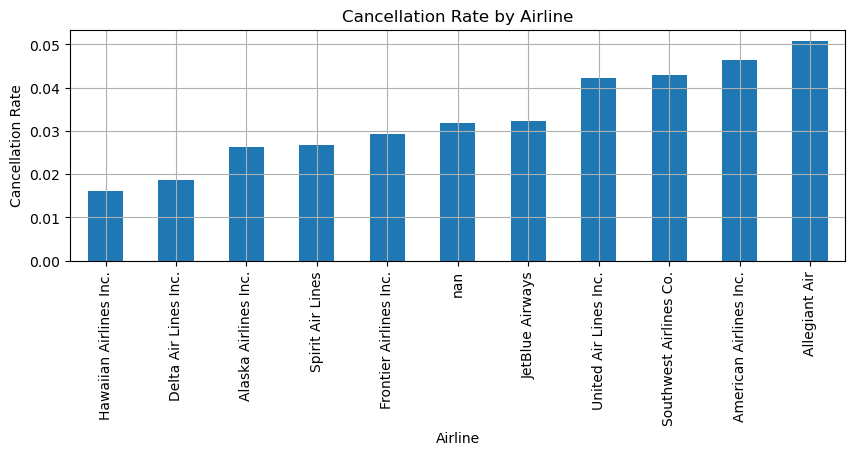

In [20]:
airline_cancelled = train_data.filter(train_data.Cancelled==True)\
.groupby('airline')\
.count()\
.withColumnRenamed('count','cancelled')\
.withColumnRenamed('airline','cancelled_airline')

airline_flights = train_data\
.groupby('airline')\
.count()\
.withColumnRenamed('count','total')

agg_table = airline_cancelled.join(airline_flights,
                                  (airline_cancelled.cancelled_airline==airline_flights.airline),
                                  "leftouter")

agg_pandas = agg_table.toPandas()
agg_pandas['cancel_rate'] = agg_pandas['cancelled']/agg_pandas['total']
agg_pandas['airline'] = agg_pandas['airline'].astype(int)

agg_cancel = agg_pandas.merge(emp,
                              left_on='airline',
                              right_on='AIRLINE_ID',
                              how='left')

agg_cancel.sort_values('cancel_rate').plot.bar(x='CARRIER_NAME',
                                               y='cancel_rate',
                                               title='Cancellation Rate by Airline',
                                              xlabel = 'Airline',
                                              ylabel = 'Cancellation Rate',
                                              legend = False,
                                              grid=True,
                                              figsize=(10,3));

## Cancellation Rate by Airport

In [22]:
airport_cancelled = train_data.filter(train_data.Cancelled==True)\
.groupby('OriginAirportSeqID')\
.count()\
.withColumnRenamed('count','cancelled')\
.withColumnRenamed('OriginAirportSeqID','cancelled_airport')

airport_flights = train_data\
.groupby('OriginAirportSeqID')\
.count()\
.withColumnRenamed('count','total')

airports = airport_cancelled.join(airport_flights,
                                  (airport_cancelled.cancelled_airport==airport_flights.OriginAirportSeqID),
                                  "leftouter").toPandas()

airports['cancelled_airport'] = airports['cancelled_airport'].astype(int)

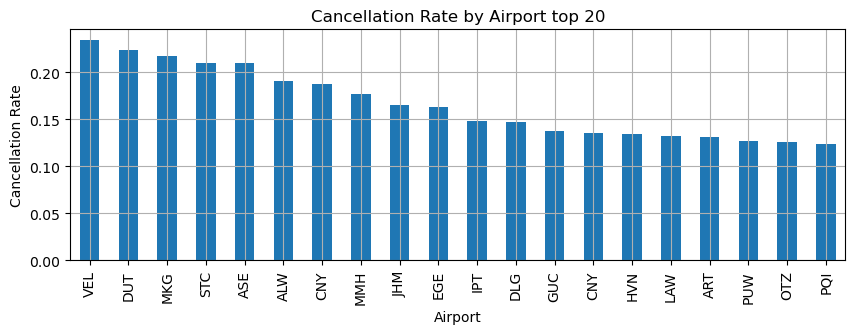

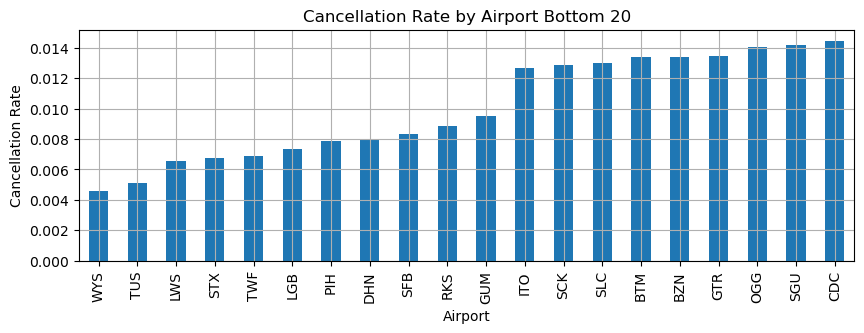

In [23]:
agg_air_cancel = airports.merge(airport_codes,
                              left_on='cancelled_airport',
                              right_on='airport_sed_id',
                              how='left')

agg_air_cancel['cancel_rate'] = agg_air_cancel['cancelled']/agg_air_cancel['total']

agg_air_cancel.dropna().sort_values('cancel_rate',ascending=False).head(20).plot.bar(x='airport',
                                               y='cancel_rate',
                                               title='Cancellation Rate by Airport top 20',
                                              xlabel = 'Airport',
                                              ylabel = 'Cancellation Rate',
                                              legend = False,
                                              grid=True,
                                              figsize=(10,3));

agg_air_cancel.dropna().sort_values('cancel_rate').head(20).plot.bar(x='airport',
                                               y='cancel_rate',
                                               title='Cancellation Rate by Airport Bottom 20',
                                              xlabel = 'Airport',
                                              ylabel = 'Cancellation Rate',
                                              legend = False,
                                              grid=True,
                                              figsize=(10,3));

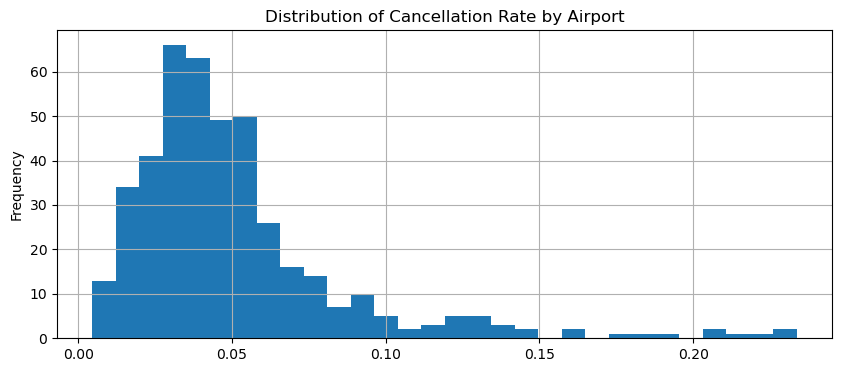

In [24]:
agg_air_cancel['cancel_rate'].plot.hist(bins=30,
                                        title='Distribution of Cancellation Rate by Airport',
                                        grid=True,
                                       figsize=(10,4));

## Rolling Cancellation Rate

In [26]:
import datetime as dt

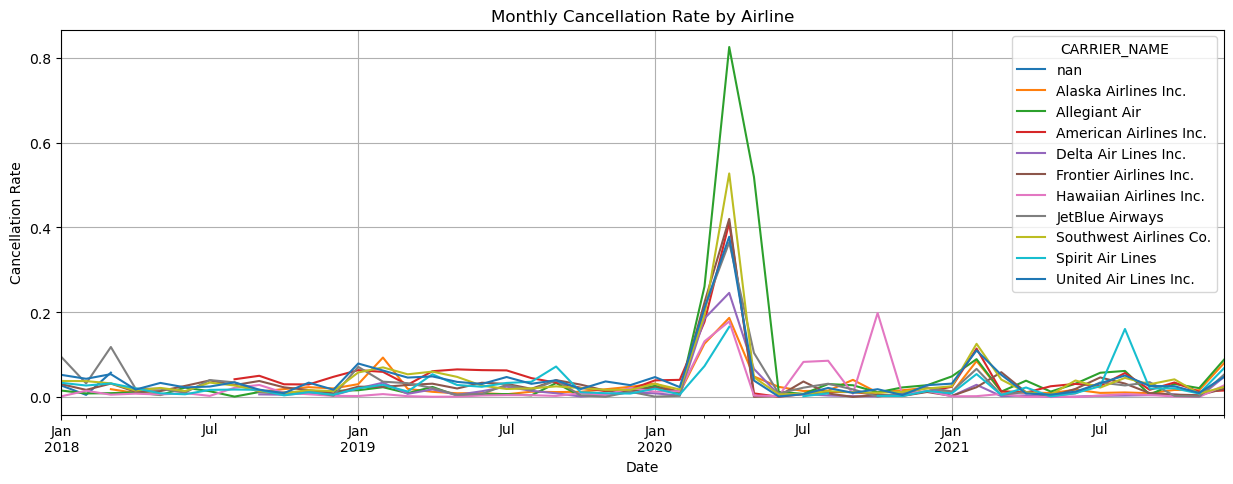

In [27]:
monthly_cancellations = train_data.select('cancel_rate','DOT_ID_Marketing_Airline','month','year').distinct().toPandas()
monthly_cancellations['Date'] = monthly_cancellations.apply(lambda x: dt.datetime(year=int(x['year']),
                                                                                  month=int(x['month']),
                                                                                  day=1),axis=1)
monthly_cancellations['DOT_ID_Marketing_Airline'] = monthly_cancellations['DOT_ID_Marketing_Airline'].astype(int)
monthly_cancellations['cancel_rate'] = monthly_cancellations['cancel_rate'].astype(float)

monthly_cancellations.merge(emp,
                            left_on='DOT_ID_Marketing_Airline',
                            right_on='AIRLINE_ID',
                              how='left')\
.pivot(index='Date',columns = 'CARRIER_NAME',values='cancel_rate').plot(figsize=(15,5),
                                                                        grid=True,
                                                                       title='Monthly Cancellation Rate by Airline',
                                                                       ylabel='Cancellation Rate');

## Correlation of Continuous Variables

In [28]:
d_corr = train_data.withColumn('Distance',train_data.Distance.cast('float'))\
 .withColumn('ORIGIN_HourlyDewPointTemperature',train_data.ORIGIN_HourlyDewPointTemperature.cast('float'))\
 .withColumn('ORIGIN_HourlyDryBulbTemperature',train_data.ORIGIN_HourlyDryBulbTemperature.cast('float'))\
 .withColumn('ORIGIN_HourlyPrecipitation',train_data.ORIGIN_HourlyPrecipitation.cast('float'))\
 .withColumn('ORIGIN_HourlyPressureChange',train_data.ORIGIN_HourlyPressureChange.cast('float'))\
 .withColumn('ORIGIN_HourlyPressureTendency',train_data.ORIGIN_HourlyPressureTendency.cast('float'))\
 .withColumn('ORIGIN_HourlyRelativeHumidity',train_data.ORIGIN_HourlyRelativeHumidity.cast('float'))\
 .withColumn('ORIGIN_HourlySkyConditions',train_data.ORIGIN_HourlySkyConditions.cast('float'))\
 .withColumn('ORIGIN_HourlySeaLevelPressure',train_data.ORIGIN_HourlySeaLevelPressure.cast('float'))\
 .withColumn('ORIGIN_HourlyStationPressure',train_data.ORIGIN_HourlyStationPressure.cast('float'))\
 .withColumn('ORIGIN_HourlyVisibility',train_data.ORIGIN_HourlyVisibility.cast('float'))\
 .withColumn('ORIGIN_HourlyWetBulbTemperature',train_data.ORIGIN_HourlyWetBulbTemperature.cast('float'))\
 .withColumn('ORIGIN_HourlyWindDirection',train_data.ORIGIN_HourlyWindDirection.cast('float'))\
 .withColumn('ORIGIN_HourlyWindGustSpeed',train_data.ORIGIN_HourlyWindGustSpeed.cast('float'))\
 .withColumn('ORIGIN_HourlyWindSpeed',train_data.ORIGIN_HourlyWindSpeed.cast('float'))\
 .withColumn('DEST_HourlyDewPointTemperature',train_data.DEST_HourlyDewPointTemperature.cast('float'))\
 .withColumn('DEST_HourlyDryBulbTemperature',train_data.DEST_HourlyDryBulbTemperature.cast('float'))\
 .withColumn('DEST_HourlyPrecipitation',train_data.DEST_HourlyPrecipitation.cast('float'))\
 .withColumn('DEST_HourlyPressureChange',train_data.DEST_HourlyPressureChange.cast('float'))\
 .withColumn('DEST_HourlyPressureTendency',train_data.DEST_HourlyPressureTendency.cast('float'))\
 .withColumn('DEST_HourlyRelativeHumidity',train_data.DEST_HourlyRelativeHumidity.cast('float'))\
 .withColumn('DEST_HourlySkyConditions',train_data.DEST_HourlySkyConditions.cast('float'))\
 .withColumn('DEST_HourlySeaLevelPressure',train_data.DEST_HourlySeaLevelPressure.cast('float'))\
 .withColumn('DEST_HourlyStationPressure',train_data.DEST_HourlyStationPressure.cast('float'))\
 .withColumn('DEST_HourlyVisibility',train_data.DEST_HourlyVisibility.cast('float'))\
 .withColumn('DEST_HourlyWetBulbTemperature',train_data.DEST_HourlyWetBulbTemperature.cast('float'))\
 .withColumn('DEST_HourlyWindDirection',train_data.DEST_HourlyWindDirection.cast('float'))\
 .withColumn('DEST_HourlyWindGustSpeed',train_data.DEST_HourlyWindGustSpeed.cast('float'))\
 .withColumn('DEST_HourlyWindSpeed',train_data.DEST_HourlyWindSpeed.cast('float'))\
 .withColumn('emp_per_flight',train_data.emp_per_flight.cast('float'))\
 .withColumn('fulltime_pct',train_data.fulltime_pct.cast('float'))\
 .withColumn('pct_filltime_mom_diff',train_data.pct_filltime_mom_diff.cast('float'))\
 .withColumn('emp_per_flight_mom_diff',train_data.emp_per_flight_mom_diff.cast('float'))\
 .select('Distance','ORIGIN_HourlyDewPointTemperature','ORIGIN_HourlyDryBulbTemperature','ORIGIN_HourlyPrecipitation',
         'ORIGIN_HourlyPressureChange','ORIGIN_HourlyPressureTendency','ORIGIN_HourlyRelativeHumidity','ORIGIN_HourlySkyConditions',
         'ORIGIN_HourlySeaLevelPressure','ORIGIN_HourlyStationPressure','ORIGIN_HourlyVisibility','ORIGIN_HourlyWetBulbTemperature',
         'ORIGIN_HourlyWindDirection','ORIGIN_HourlyWindGustSpeed','ORIGIN_HourlyWindSpeed','DEST_HourlyDewPointTemperature',
         'DEST_HourlyDryBulbTemperature','DEST_HourlyPrecipitation','DEST_HourlyPressureChange','DEST_HourlyPressureTendency',
         'DEST_HourlyRelativeHumidity','DEST_HourlySkyConditions','DEST_HourlySeaLevelPressure','DEST_HourlyStationPressure',
         'DEST_HourlyVisibility','DEST_HourlyWetBulbTemperature','DEST_HourlyWindDirection','DEST_HourlyWindGustSpeed',
         'DEST_HourlyWindSpeed','emp_per_flight','fulltime_pct','pct_filltime_mom_diff','emp_per_flight_mom_diff').dropna()

In [29]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=d_corr.columns, outputCol=vector_col)
df_vector = assembler.transform(d_corr).select(vector_col)

/opt/conda/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [ ]:
matrix = Correlation.corr(df_vector, vector_col)
vals = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(33,33)
cor_df = pd.DataFrame(vals,index=d_corr.columns,columns=d_corr.columns)

In [32]:
import seaborn as sns

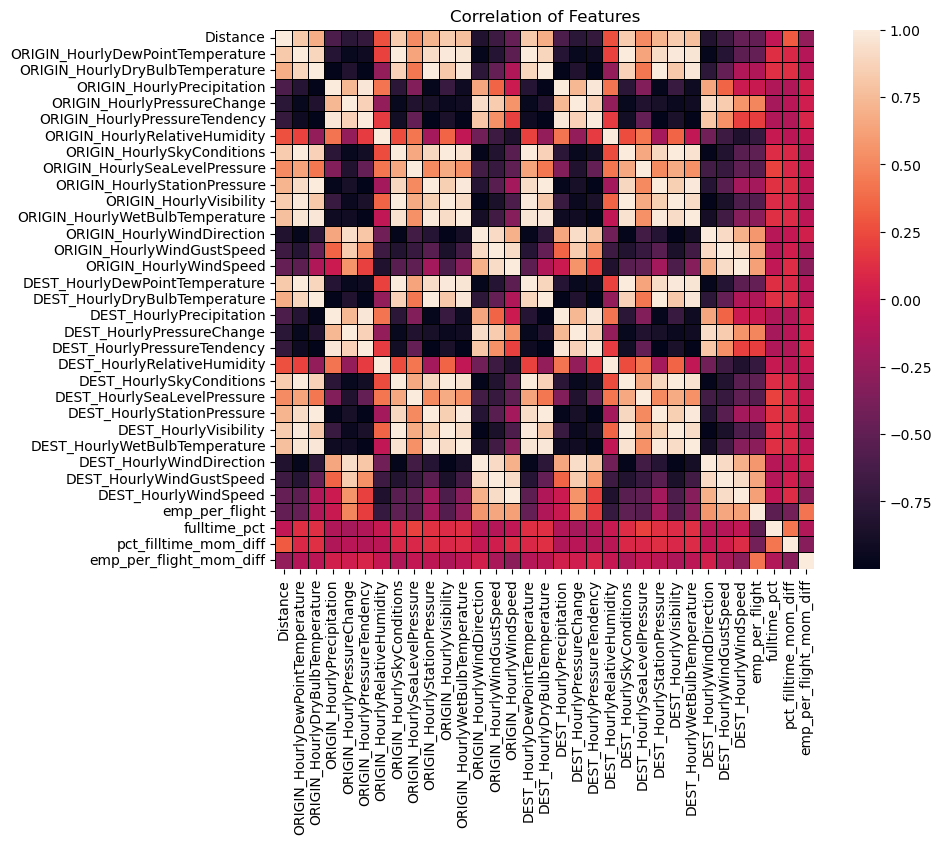

In [33]:
plt.figure(figsize=(10,7))
sns.heatmap(cor_df,linecolor='black',linewidth=0.5,square=True)
plt.title('Correlation of Features')
plt.show()